# Intelligent task allocation and management agent

Task management remains one of the most persistent challenges in professional and academic environments. When faced with complex projects, individuals often struggle with where to begin, how to prioritize subtasks, and what approach aligns best with their working style. This uncertainty frequently leads to procrastination and inefficient workflows.

This notebook presents an intelligent agent that addresses these challenges by analyzing user work patterns and generating personalized task execution plans. By combining behavioral analysis with external knowledge retrieval, the system creates customized workflows that match individual preferences and optimize productivity.

The core innovation lies in the agent's ability to understand how users naturally approach tasks - whether they prefer detailed planning phases, iterative development, or systematic step-by-step execution - and then tailoring recommendations accordingly. This personalization transforms vague project requirements into actionable, structured plans that feel intuitive to execute.

In [1]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import START, StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image, Markdown
from dotenv import load_dotenv

from tavily import TavilyClient

# Load environment variables
load_dotenv()

# Set OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

* `TypedDict`, `Annotated`, `List`: These are part of Python’s `typing` module and help define structured data types with better code clarity and type safety.
  * `TypedDict` lets us define a dictionary with specific field names and expected types — crucial for defining the agent's evolving state.
  * `Annotated` is used in some LangChain use-cases to enrich types with metadata (though not directly used here).
* `StateGraph`, `START`, `END`: These come from LangGraph and allow us to define a directed graph where each node represents a processing step in the agent.
  * `START` and `END` help declare the entry and exit points of the workflow pipeline.
* `BaseMessage`, `HumanMessage`, `ToolMessage`: These are internal message formats used by LangChain to simulate conversations or prompt exchanges:
    * `BaseMessage`: The abstract parent for all message types.
    * `HumanMessage`: Represents natural language input from the user.
    * `ToolMessage`: Represents structured outputs from tools (e.g., retrieval results or agent actions).
  * These abstractions make it easier to pass inputs/outputs consistently through tools and LLMs.
* `ChatPromptTemplate`: Allows for clean, modular prompt design — like defining a message template with variables (`{task}`, `{style}`, etc.) to be filled in dynamically.
* `MessagesPlaceholder`: Used when a prompt needs to inject an entire message history (useful in chat-based interactions).
* `MermaidDrawMethod`: Used to visualize LangGraph workflows in Mermaid.js syntax.
* `TavilyClient`: This client allows the agent to perform real-time internet searches. It is essential for enriching the agent’s knowledge beyond the static training of the LLM — particularly useful when task details are domain-specific or time-sensitive.


### State management architecture
The workflow state serves as the central data structure that flows through our processing pipeline. We define a structured state that captures all necessary information at each stage of the analysis.

In [2]:
class ApproachState(TypedDict):
    plan: str  # Generated workflow with detailed execution steps
    style: str  # Analyzed working style preferences from historical data
    task: str  # Original user input describing the desired task
    details: str # internet retrieval about task requirements
    history: str # description of history approaches

This TypedDict structure ensures type safety while providing a clear contract for data flow between processing nodes. Each field serves a specific purpose in building toward the final personalized recommendation, with the state evolving as it moves through our analysis pipeline.

### LLM & web search service initialization
We establish connections to two key back-end services that our intelligent agent depends on:
- A language model from OpenAI, which powers reasoning, analysis, and response generation.
- A web search API via Tavily, which enables the agent to access real-time information from the internet — essential for tailoring responses to current knowledge or domain-specific tasks.

Together, these tools form the cognitive engine and external knowledge interface of our system. Initializing them properly ensures the pipeline has access to both reasoning capabilities and up-to-date information, allowing it to craft personalized and well-informed task plans.

In [3]:
# Initialize the ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

# Initialize Tavily client for performing real-time web searches
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

- The `ChatOpenAI` object sets up a chat-oriented interface to OpenAI’s GPT model. This object allows us to easily invoke the model with prompts, enabling the agent to generate analyses, custom plans, and summaries based on provided inputs.
- The `TavilyClient` is initialized with an API key and provides a simple interface for performing web searches. This will later allow the system to enrich tasks with external data — such as technical steps, background research, or contextual best practices — all fetched dynamically from the web.

### Component functions
To build an intelligent task allocation system that is adaptive and context-aware, we decompose the logic into modular stages. Let's understand the three-stage pipeline that powers our intelligent task allocation system:
- Behavioral analysis: Examines historical work patterns to identify user preferences.
- Knowledge retrieval: Gathers external information about task requirements and best practices.
- Personalized planning: Synthesizes insights to generate customized execution strategies.

#### Behavioral analysis engine
The goal here is to understand how the user tends to approach work — are they a step-by-step planner? Do they dive into action early? Are they cautious, analytical, or spontaneous?

This component achieves that by analyzing past task descriptions or reflections stored in text files. It aggregates that historical data and feeds it to a language model, which then extracts behavioral traits. These traits will later be used to guide how future plans are structured — making the entire system more personalized.

In [4]:
# Function 1: Behavioral pattern analysis - analyze historical work patterns to identify user's preferred working style
def approach_analysis(approach: ApproachState) -> ApproachState:
    """Retrieve history approach and let LLM do a qualitative analysis on user approach preference."""
    history = ""
    # Read all historical work records from the history directory
    for h in os.listdir(f"{os.getcwd()}/history"):
        if (h[-4:] == ".txt"):  # Process only text files
            with open(os.path.join(os.getcwd(), f"history/{h}")) as f:
                content = f.readlines()
            history = f"{history}\n{content[0]}"  # Append the first line from each file to our history string

    # Store combined history into the agent's internal state
    approach['history'] = history

    # Create prompt template for style analysis
    prompt = ChatPromptTemplate.from_template(
        "Analyze the work style the following summary of work history portrays. "
        "Provide a brief summary the preference in work style."
        "\n\nWork History: {history}"
    )

    # Generate style analysis using LLM
    style = llm.invoke(prompt.format(history=approach['history']))

    # Store the inferred style back into the shared state
    approach['style'] = style
    return approach

- This function reads historical user task descriptions from a local folder (`/history`). These might be journaled task logs, summaries, or feedback reflections from previous work.
- It compiles the text from these files into a single string that serves as the dataset for behavior inference.
- It then constructs a prompt dynamically, injecting this history into a templated question asking the LLM to identify behavioral tendencies.
- The model’s output — a summary of the user’s work style — is then stored in the workflow’s state dictionary under the key `'style'` of the `ApproachState` object.

This makes it possible for the next stages of the pipeline to adapt to how a person likes to work, not just what needs to be done. By learning from past behavior, the system builds a soft behavioral fingerprint that guides decision-making in later planning.


#### External knowledge retrieval system
The second phase of our intelligent task planning pipeline focuses on information gathering. No matter how clear our workflow style is, it's nearly impossible to plan effectively without context on what the task entails.

This component taps into the Tavily web search API, which provides intelligent, curated web search results for a given query. We use it to retrieve task-relevant steps, best practices, and background knowledge — helping the AI generate practical and grounded plans.

The function builds a tailored search query from the user’s task, submits it to Tavily, and then aggregates the responses into a textual knowledge base. This context is stored in the task state and passed forward to inform the final planning stage.

In [5]:
# Function 2: Task knowledge retrieval - Retrieve comprehensive information about the task using intelligent web search
def task_manifest(approach: ApproachState) -> ApproachState:
    """use Tavily to look up information on the task."""

    # Construct a search query to retrieve best practices or standard procedures for task-specific information
    search_foundation = "What are the steps for the following task? {task}"
    search_query = search_foundation.format(task=approach["task"])

    # Query Tavily search engine with the constructed query
    searches = tavily_client.search(search_query, max_results=10)

    details = ""
    # Iterate over results to build a composite knowledge string
    for result in searches['results']:
        if details == "":
            details = result['content']
        else:
            details = f"{details} {result['content']}"  # Concatenate retrieved content

    # Store the retrieved knowledge back in the task state
    approach["details"] = details

    return approach

From a systems perspective, this function performs dynamic query generation and unstructured data aggregation:
- It creates a natural-language question tailored to the user’s input — something like “What are the steps for building a smoke detector?”
- This query is submitted to the Tavily client, which returns up to 10 highly relevant search results (each result being a snippet of content).
- These snippets are concatenated into a single document, forming a basic retrieved context window.
- The compiled content is stored in the shared task state under the "details" key, and used later to guide the LLM in generating a concrete plan.

This ensures that the agent is not working in a vacuum. Instead, it has immediate access to publicly available knowledge that is specific to the task, helping it bridge the gap between personalized workflows and real-world feasibility.

#### Personalized plan generation
This final component is where all our upstream efforts come together. Having understood the user's preferred working style and retrieved task-specific domain knowledge, we now synthesize these insights into a custom execution plan.

The idea is simple but powerful: tailor a step-by-step workflow that not only logically solves the task at hand, but also aligns with how the user tends to approach work. This improves engagement, reduces friction, and promotes productivity — especially for tasks that are complex or unfamiliar.

To do this, we construct a prompt that feeds the LLM all relevant context (task definition, retrieved knowledge, and work style insights), and ask it to produce an annotated sequence of steps. Each step is explained and explicitly shaped around the user's behavior.

In [6]:
# Function 3: Customized approach generation - generate personalized task execution plan by combining user work style
def result_approach(approach: ApproachState) -> ApproachState:
    # Create comprehensive prompt that integrates all gathered insights
    prompt = ChatPromptTemplate.from_template(
        "Give me a plan of steps to carry out the following task with custom work styles specified."
        "You have to pay extra attention to Work Style mentioned below and adjust the plan accordingly."
        "\n\nTask: {task}\n\nDetails: {details}\n\nWork Style: {style}\n\n"
        "The output must be a numbered list of steps with explanation of why it is needed, what to do and how it considers the Work Style."
    )

    # Generate personalized plan using integrated prompt
    suggestion = llm.invoke(prompt.format(task=approach["task"], details=approach["details"], style=approach["style"]))

    # Store the output plan back in the agent state
    approach['plan'] = suggestion

    return approach

At this point, the function acts as the planning layer of the pipeline:
- It uses a structured prompt template to combine all prior knowledge: the user’s natural work tendencies, detailed information about the task, and the task's original intent.
- The prompt explicitly asks the LLM to pay attention to the work style and explain why each suggested step matters — not just what to do.
- This helps ensure the output feels human-aligned, not robotic — more like advice from a productivity coach than a rigid checklist.
- The output (a rich, numbered plan with contextual reasoning) is written into the shared agent state under the `"plan"` key.

This component is the heart of the system — turning introspection and research into real, actionable structure. The result is a task plan that’s both smart and deeply personalized.

### Graph workflow building
Now we construct the state graph that orchestrates our three-stage pipeline, defining the flow of information and ensuring proper sequencing of analysis components.

In [7]:
# Initialize the StateGraph
workflow = StateGraph(ApproachState)

# Add nodes to the graph
workflow.add_node("approach_analysis", approach_analysis)
workflow.add_node("task_knowledge_retrieval", task_manifest)
workflow.add_node("customized_approach_generation", result_approach)

# Define and add conditional edges
workflow.add_edge("approach_analysis", "task_knowledge_retrieval")
workflow.add_edge("task_knowledge_retrieval", "customized_approach_generation")

# Set the entry point
workflow.set_entry_point("approach_analysis")

# Set the exit point
workflow.add_edge("customized_approach_generation", END)

# Compile the graph
app = workflow.compile()

This graph structure ensures proper data flow and maintains state consistency throughout the processing pipeline. Each node transforms the state in specific ways, building toward the final personalized recommendation through a logical sequence of analysis and synthesis steps.

#### Workflow visualization
Understanding complex workflows becomes easier with visual representation. Let's generate a diagram that illustrates our processing pipeline.

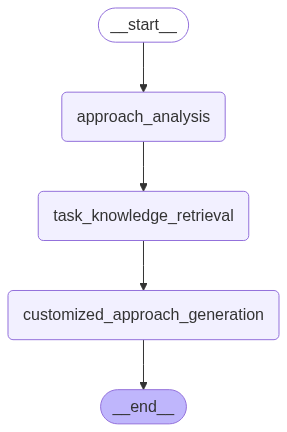

In [8]:
# Generate and display workflow diagram
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

This visualization creates a clear representation of how information flows through our system, making it easier to understand the relationships between different processing stages and identify potential optimization opportunities.

### Agent calling function
We create a clean interface that abstracts the complexity of our workflow system and provides a simple entry point for users to generate personalized task plans.

In [9]:
# Main interface function that orchestrates the complete workflow - takes a task description and returns a comprehensive personalized plan
def approach(task: str) -> ApproachState:
    # Initialize empty state structure
    init_approach = ApproachState(
        task=task,
        plan="",
        style="",
        history="",
        details=""
    )

    # Execute the complete workflow pipeline
    response = app.invoke(init_approach)
    return response

This interface function encapsulates the entire workflow of our multi-stage analysis system into a single, intuitive function call. Users can simply provide their task description and receive a comprehensive, personalized execution plan without needing to understand the underlying workflow mechanics.

### Example
Let's demonstrate our system with a real-world example that showcases how the agent transforms a broad project vision into a structured, actionable plan. This is an example where the user hopes to build a smoke detector that is futuristic in design and accessible for installation.

In [10]:
# Define a task that requires both technical and design considerations
query = """
    I want to build a smoke detector device! I am visioning it with futuristic design and hope to maximize the ability to install it anywhere. Perhaps keep it small and energy efficient for that purpose!
    """

# Execute the workflow and generate personalized recommendations
## Some history is being fed into the Agent. It helps the agent understand users' approach preferences
generated_plan = approach(task=query)

# Display results
print(f"Task:\n")
print(f"{generated_plan['task']}\n")
print(f"Style:\n")
print(f"{generated_plan['style']}\n")
print(f"Steps:\n")
generated_plan['plan'].pretty_print()

Task:


    I want to build a smoke detector device! I am visioning it with futuristic design and hope to maximize the ability to install it anywhere. Perhaps keep it small and energy efficient for that purpose!
    

Style:

content='The work style presented in the summary indicates a pragmatic and action-oriented approach, coupled with a preference for straightforward tasks over complex ones. The individual exhibits a tendency to prioritize efficiency in job applications by avoiding lengthy responses, suggesting a preference for simplicity and a direct approach to tasks. Their strategy for solving problem sets highlights a methodical pattern: starting with easier problems to build confidence and familiarity before tackling more complex challenges. \n\nAdditionally, the proactive decision to address regulatory challenges with the FDA and EMA at the outset of a medical IT venture indicates a forward-thinking mindset, focusing on preventing long-term obstacles rather than just immediate

This example demonstrates how our system handles complex, multi-dimensional tasks that involve technical implementation, design considerations, and practical constraints. The generated plan will reflect not only best practices in hardware development but also the user's specific preferences for approaching such projects.